# STAT 201 Project Proposal (Group 16)
## Comparison of Break and Enter Crime in West Point Grey, Vancouver, BC pre- and post-COVID

## 1. Introduction

In late 2019, COVID-19 was first identified in Wuhan, China. It has since spread globally and was declared a pandemic by the World Health Organization in March 2020. In March 18, 2020, the BC provincial government declared a state of emergency, and implemented a number of restrictions to help slow the spread of the virus, encouraging people to stay home as much as possible.
Past research has shown that the lockdown implemented in response to the COVID-19 pandemic has had various effects, including a reduction in crime rates in general (Buil-Gil et al.; Shen et al.). We want to investigate whether or not there is a difference in break and enter (denoted hereafter as B&E) crime rate comparing during COVID and pre-COVID times. More specifically, we want to look at the West Point Grey neighbourhood in Vancouver, regarding the time period from March 2020 to February 2022 for during COVID, and March 2018 to February 2020 for pre-COVID.

## 2. Preliminary Results

We begin by loading the necessary R libraries for data wrangling and statistical inference.

In [1]:
library(tidyverse)
library(broom)
library(infer)
library(zoo)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Next, we read the data from CSV files downloaded from the Vancouver Police Department (https://geodash.vpd.ca/opendata/) for the years 2018-2022 in the neighbourhood West Point Grey. This data is combined into a single data frame, cleaned, and classified into pre- and post-COVID crimes.

In [2]:
# Read CSV files for 2018-2022
west_point_grey_2018 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2018.csv", show_col_types = FALSE)
west_point_grey_2019 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2019.csv", show_col_types = FALSE)
west_point_grey_2020 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2020.csv", show_col_types = FALSE)
west_point_grey_2021 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2021.csv", show_col_types = FALSE)
west_point_grey_2022 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2022.csv", show_col_types = FALSE)

# Bind all CSV files into a single data frame, 
# select variables of interest (TYPE, YEAR, MONTH),
# filter and classify crimes as pre- and post-COVID
wpg <- rbind(west_point_grey_2018, 
             west_point_grey_2019,
             west_point_grey_2020,
             west_point_grey_2021,
             west_point_grey_2022) |>
    select(TYPE, YEAR, MONTH) |>
    filter((YEAR == 2018 & MONTH > 2) | YEAR == 2019 | YEAR == 2020 | YEAR == 2021 | (YEAR == 2022 & MONTH < 3)) |>
    mutate(PERIOD = case_when(((YEAR == 2018 & MONTH > 2) | YEAR == 2019 | (YEAR == 2020 & MONTH < 3)) ~ 'pre',
                              ((YEAR == 2020 & MONTH > 2) | YEAR == 2021 | (YEAR == 2022 & MONTH < 3)) ~ 'post')) |>
    mutate(TYPE = as.factor(TYPE),
           PERIOD = as.factor(PERIOD))

head(wpg)

TYPE,YEAR,MONTH,PERIOD
<fct>,<dbl>,<dbl>,<fct>
Break and Enter Commercial,2018,5,pre
Break and Enter Commercial,2018,5,pre
Break and Enter Commercial,2018,9,pre
Break and Enter Commercial,2018,11,pre
Break and Enter Commercial,2018,9,pre
Break and Enter Commercial,2018,12,pre


Breaking down the data month-by-month in the form of a barplot, we see that there is a spike in B&E immediately following COVID restrictions (March 2020, represented by the vertical black line) (Figure 1).

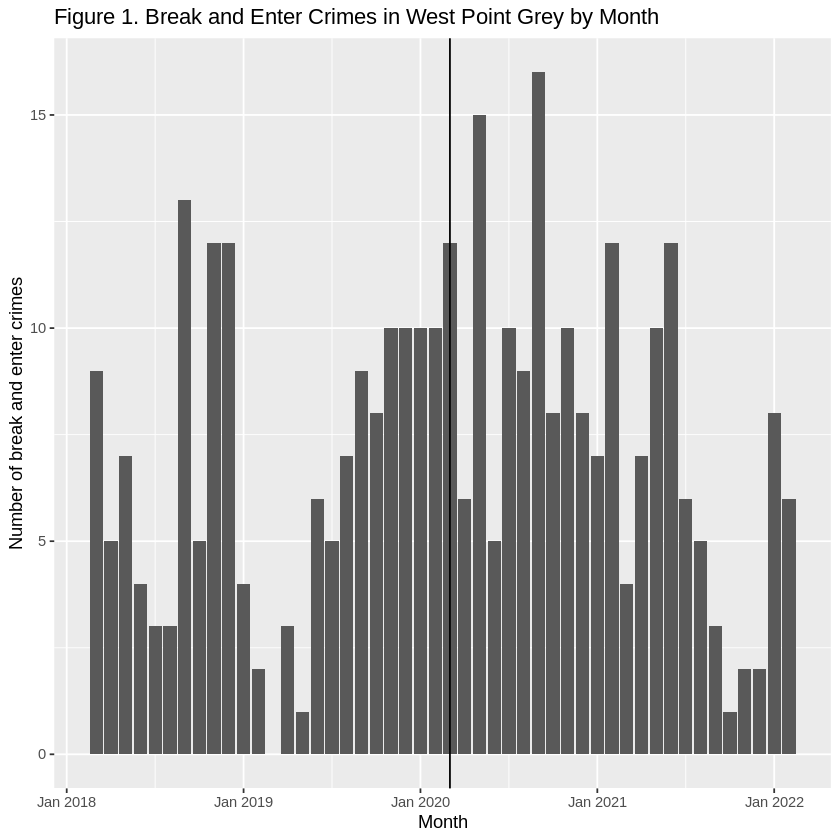

In [3]:
line_plot <- wpg |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    mutate(YEARMON = as.yearmon(paste(YEAR, MONTH), "%Y %m")) |> # Convert YEAR and MONTH columns to date
    ggplot() +
    geom_bar(aes(x = YEARMON)) +
    geom_vline(xintercept = as.yearmon(paste(2020, 03), "%Y %m")) + # Vertical line at March 2020
    labs(title = "Figure 1. Break and Enter Crimes in West Point Grey by Month",
         x = "Month", 
         y = "Number of break and enter crimes")

line_plot

Next, we calculate summary statistics for the proportion of B&E (out of all crimes) across both time periods.

In [4]:
summary_tibble <- wpg |>
    group_by(PERIOD) |>
    summarize(n_break = sum(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other"),
              n_total = n()) |>
    mutate(prop_break = n_break / n_total)

summary_tibble

PERIOD,n_break,n_total,prop_break
<fct>,<int>,<int>,<dbl>
post,184,780,0.2358974
pre,158,882,0.1791383


A visual representation of the data is below, in the form of a stacked barplot.

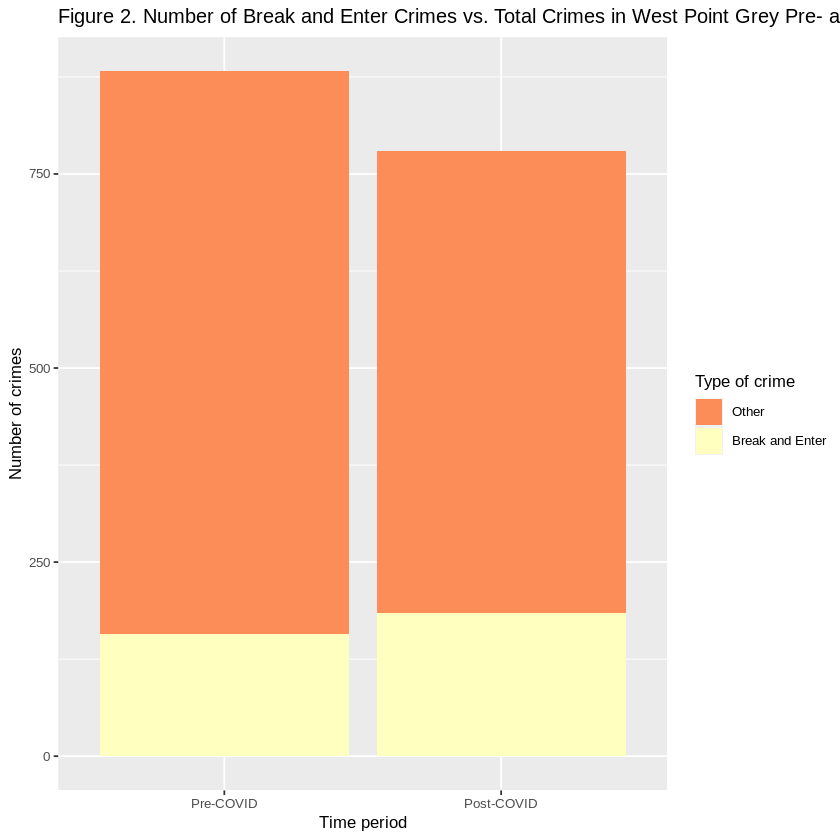

In [5]:
stacked_barplot <- wpg |>
    mutate(TYPE = case_when(((TYPE != "Break and Enter Commercial") & (TYPE != "Break and Enter Residential/Other")) ~ "Other",
                           ((TYPE == "Break and Enter Commercial") | (TYPE == "Break and Enter Residential/Other")) ~ "Break and Enter")) |>
    ggplot() +
    geom_bar(aes(x = factor(PERIOD, levels = c("pre", "post")), fill = factor(TYPE, levels = c("Other", "Break and Enter")))) +
    scale_x_discrete(labels = c("pre" = "Pre-COVID", "post" = "Post-COVID")) +
    labs(title = "Figure 2. Number of Break and Enter Crimes vs. Total Crimes in West Point Grey Pre- and Post-COVID", 
         x = "Time period", 
         y = "Number of crimes", 
         fill = "Type of crime") +
    theme(text = element_text(size = 10)) +
    scale_fill_brewer(palette = "Spectral")

stacked_barplot

We can observe from the summary table and the barplot that the total number of crimes decreased post-COVID, but the number of B&E increased. Is this difference significant?

Setting `type = "bootstrap"` in `generate()`.



lower_ci,upper_ci
<dbl>,<dbl>
0.02036205,0.09364916


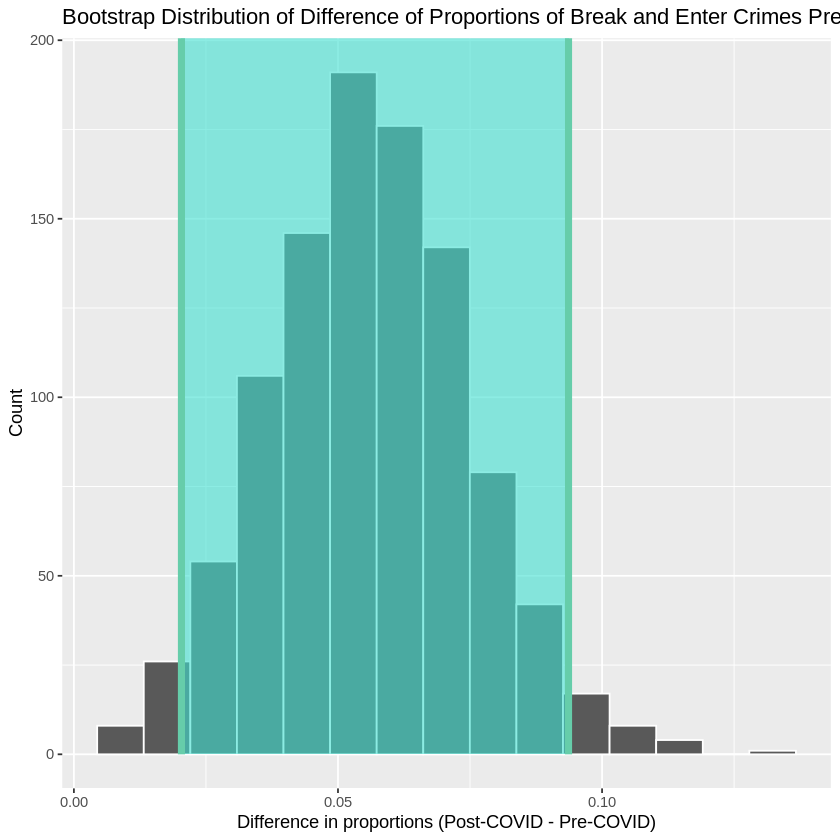

In [98]:
set.seed(2023)

bootstrap_reps <- 1000

diff_in_props_bootstrap <- wpg |>
    mutate(TYPE = case_when(((TYPE != "Break and Enter Commercial") & (TYPE != "Break and Enter Residential/Other")) ~ "Other",
                           ((TYPE == "Break and Enter Commercial") | (TYPE == "Break and Enter Residential/Other")) ~ "Break and Enter")) |>
    specify(TYPE ~ PERIOD, 
            success = "Break and Enter") |>
    generate(reps = bootstrap_reps) |>
    calculate(stat = "diff in props", order = c("post", "pre"))

diff_in_props_ci <- diff_in_props_bootstrap |>
    get_confidence_interval(level = 0.95, type = "percentile")

diff_in_props_ci

diff_in_props_bootstrap_dist <- diff_in_props_bootstrap |>
    visualize() +
    shade_confidence_interval(diff_in_props_ci) +
    labs(title = "Bootstrap Distribution of Difference of Proportions of Break and Enter Crimes Pre- and Post-COVID",
         x = "Difference in proportions (Post-COVID - Pre-COVID)",
         y = "Count")

diff_in_props_bootstrap_dist

statistic,chisq_df,p_value,alternative,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
8.159535,1,0.002141768,greater,0.03675822,1


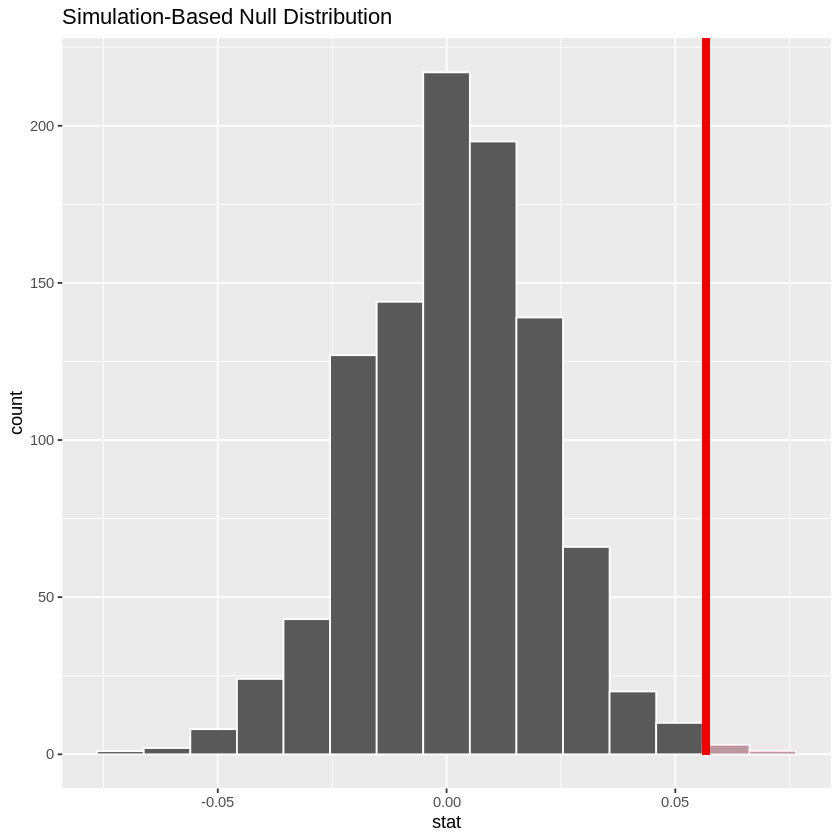

In [22]:
prop_test <- wpg |>
    mutate(TYPE = case_when(((TYPE != "Break and Enter Commercial") & (TYPE != "Break and Enter Residential/Other")) ~ "Other",
                           ((TYPE == "Break and Enter Commercial") | (TYPE == "Break and Enter Residential/Other")) ~ "Break and Enter")) |>
    prop_test(TYPE ~ PERIOD,
              success = "Break and Enter",
           order = c("post", "pre"),
            alternative = "greater",

             correct = FALSE)

prop_test

null_distribution <- wpg |>
    mutate(TYPE = case_when(((TYPE != "Break and Enter Commercial") & (TYPE != "Break and Enter Residential/Other")) ~ "Other",
                           ((TYPE == "Break and Enter Commercial") | (TYPE == "Break and Enter Residential/Other")) ~ "Break and Enter")) |>
    specify(TYPE ~ PERIOD, 
            success = "Break and Enter") |>
    hypothesize(null = "independence") |>
    generate(reps = 1000, type = "permute") |>
    calculate(stat = "diff in props", order = c("post", "pre"))

diff_in_props <- wpg |>
    mutate(TYPE = case_when(((TYPE != "Break and Enter Commercial") & (TYPE != "Break and Enter Residential/Other")) ~ "Other",
                           ((TYPE == "Break and Enter Commercial") | (TYPE == "Break and Enter Residential/Other")) ~ "Break and Enter")) |>
    specify(TYPE ~ PERIOD, 
            success = "Break and Enter") |>
    calculate(stat = "diff in props", order = c("post", "pre"))

diff_in_props_shaded <- null_distribution |>
    visualize() +
    shade_p_value(obs_stat = diff_in_props, direction = "right")

diff_in_props_shaded

In [23]:
summary_tibble

PERIOD,n_break,n_total,prop_break
<fct>,<int>,<int>,<dbl>
post,184,780,0.2358974
pre,158,882,0.1791383


In [41]:
p_post = summary_tibble[1, 4] |> pull()
p_pre = summary_tibble[2, 4] |> pull()
p_pooled = ((summary_tibble[1, 2] + summary_tibble[2, 2]) / 
           (summary_tibble[1, 3] + summary_tibble[2, 3])) |> pull()
n_post = summary_tibble[1, 2] |> pull()
n_pre = summary_tibble[2, 2] |> pull()

z_stat = (p_post - p_pre) / sqrt(p_pooled * (1 - p_pooled) * ((1 / n_post) + (1 / n_pre)))
z_stat_2 = (0.236 - 0.179) / sqrt(0.206 * (1 - 0.206) * ((1 / 780) + (1 / 882)))

z_stat_2

p_value_z = pnorm(z_stat_2, lower.tail = FALSE)

p_value_z

prop_test_z = prop.test(
    x = c(184, 158),
    n = c(780, 882),
    alternative = "greater",
    correct = FALSE)

prop_test_z

[1] 2.867458

[1] 0.002068918


	2-sample test for equality of proportions without continuity
	correction

data:  c(184, 158) out of c(780, 882)
X-squared = 8.1595, df = 1, p-value = 0.002142
alternative hypothesis: greater
95 percent confidence interval:
 0.02395221 1.00000000
sample estimates:
   prop 1    prop 2 
0.2358974 0.1791383 


## 3. Methods: Plan

For our analysis, we will apply both the bootstrap method and asymptotic theory. Bootstrapping allows us to study the sampling distribution of B&E that would otherwise be unknown without making assumptions regarding the distribution. However, we can also make assumptions that would allow us to apply asymptotic theory, specifically Central Limit Theorem (CLT) since we know our sample was taken independently, has appropriate size and can produce a random estimator. CLT allows us to derive useful estimations of a normal distribution and apply them to make inferences about the data.

As part of our preliminary results, we observed that a higher proportion of B&E post-COVID. However, we do not yet know if this difference is statistically significant, which we will address using the following steps: (1) explicitly state our null hypothesis (H0:p=p0, H1:p<p0), (2) obtain the null distribution using infer package, (3) obtain observed test statistics, (4) obtain p-value, (5) conclude whether null hypothesis is rejected or not at the 95% significance level, (6) obtain standard-error-based CI at 95% level (7) find mean and standard deviation of the difference in proportions.

To summarize, we expect to find whether there the increase in proportion of B&E is statistically significant. This finding could inform future research and perhaps derive causal questions such as: Why did B&E become more frequent during COVID years when compared to other crimes? How did crimes that are similar in nature with B&E change during COVID time and what does that reflect about the impact of COVID on particular groups? The impact of our findings could inform criminal studies and social studies on B&E crimes and COVID-related societal impact.

## 4. References

VPD OPEN DATA. https://geodash.vpd.ca/opendata/. Last accessed Mar 18, 2023.

Buil-Gil, David, et al. “Offline Crime Bounces Back to Pre-Covid Levels, Cyber Stays High: Interrupted Time-Series Analysis in Northern Ireland.” Crime Science, vol. 10, no. 1, 2021, https://doi.org/10.1186/s40163-021-00162-9.

Shen, Yichen, et al. “COVID-19's Lockdown and Crime Victimization: The State of Emergency under the Abe Administration.” Asian Economic Policy Review, vol. 16, no. 2, 2021, pp. 327–348., https://doi.org/10.1111/aepr.12339. 